<a href="https://colab.research.google.com/github/meierkilian/iapr2020_gkj/blob/master/labs/lab_02_object_description_jerome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

# Comments by Kilian
- !! Change base path befor submitting and drive mounting
- Fourier descriptor using active contour and OpenCV for 0 & 1 and 2 & 3

Futher work
- Add comments and discussion
- Better active contour parameter
- Test Freeman coding ?
- For 0 & 1 do simple elongation comparison 
- Perform classification (but might be the next lab)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [0]:
import tarfile
import os

# !!!!!!!!!!!!!!!!!!!!!!!!!! CHANGE THIS BEFOR HANDING IN !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!! CHANGE THIS BEFOR HANDING IN !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!! CHANGE THIS BEFOR HANDING IN !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# data_base_path = os.path.join(os.pardir, 'data')
data_base_path = '/content/drive/My Drive/data'

data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

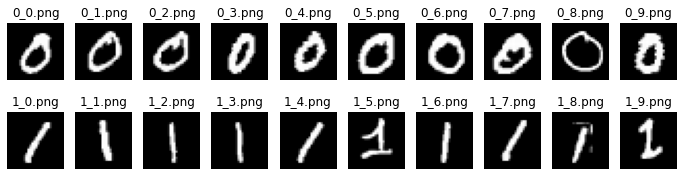

In [23]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
#data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from skimage.util import img_as_ubyte
from skimage.morphology import disk
from skimage.morphology import erosion
from skimage.morphology import closing
from skimage.morphology import opening
from skimage.morphology import rectangle
from skimage.morphology import area_closing
from skimage.morphology import area_opening
from skimage.draw import rectangle
from skimage.draw import circle
from skimage.measure import label
from skimage.color import rgb2gray
from skimage import filters
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage.filters import sobel
from skimage.filters import median

import cv2 

In [0]:
def get_contour(im, methode = "AC") :
    im = median(im, disk(2))
    #thresh = 60 #threshold to binarize the picture (either 0 or 255) 
    #im[im <= thresh] = 0
    #im[im >  thresh] = 255
    im = area_opening(im, 40)

    if methode == "AC" :
        s = np.linspace(0, 2*np.pi, 300) #have to decide how many points return good results : 300 seem a bit much !
        r = 14 + 10*np.sin(s) #initial points x coordinates
        c = 14 + 10*np.cos(s) #initial points y coordinates
        init = np.array([r, c]).T  #initial snake

        snake = active_contour(im, init, alpha=4, beta=1, gamma=1, #parameters to be adjusted
                           w_line = 0, w_edge = 2, coordinates='rc')
    elif methode == "CV2" :
        contours, hierarchy = cv2.findContours(im,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        
        c = np.array(contours[0])

        snake = np.array([c[:,0,1],c[:,0,0]]).T
        
    else :
        raise Exception("Unkown methode : {}".format(methode))

    return im, snake

In [0]:
def extract_fourier_descriptor(im, methode = "AC"):
    """
    Given a greysclale picture im, return its fourier descriptors and the contour used to compute it.
    
    """
    im, snake = get_contour(im, methode)
    
    z = (snake[:,0] + 1j*snake[:,1]) #put the 2D points of the snake in a complex representation

    return np.fft.fft(z), snake, im 

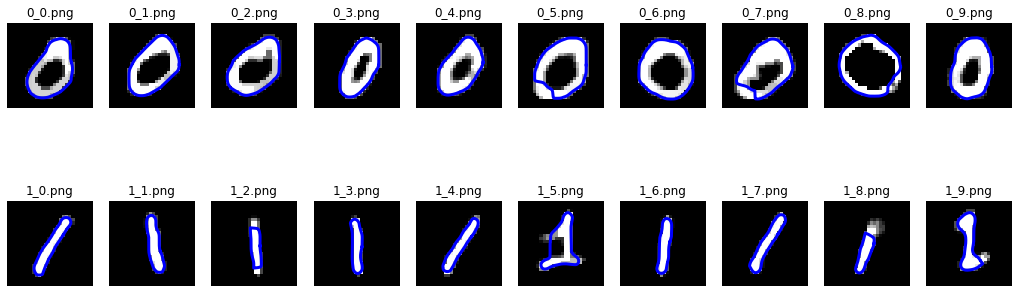

In [274]:
Zs_AC_01 = [ [] for i in np.arange( len(zeros_im) + len(ones_im) ) ]
snakes = list(im) #copy only the content, not the reference
im_prepro = list(im) #copy only the content, not the reference
for idx in np.arange(len(zeros_im)):
    Zs_AC_01[idx], snakes[idx], im_prepro[idx] = extract_fourier_descriptor(zeros_im[idx], "AC")
    Zs_AC_01[idx + len(zeros_im)], snakes[idx+ len(zeros_im)], im_prepro[idx+ len(zeros_im)] = extract_fourier_descriptor(ones_im[idx], "AC")
    

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(18, 6))
for idx, ax, im, nm in zip(np.arange(len(zeros_im)), axes[0], zeros_im, zeros_names):
    #ax.plot(init[:, 1], init[:, 0], '--r', lw=3)  #initial snake, not needed
    ax.plot(snakes[idx][:, 1], snakes[idx][:, 0], '-b', lw=3)
    ax.imshow(im_prepro[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for idx, ax, im, nm in zip(np.arange(len(ones_im)), axes[1], ones_im, ones_names):
    ax.plot(snakes[idx+ len(zeros_im)][:, 1], snakes[idx+ len(zeros_im)][:, 0], '-b', lw=3)
    ax.imshow(im_prepro[idx+ len(zeros_im)], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

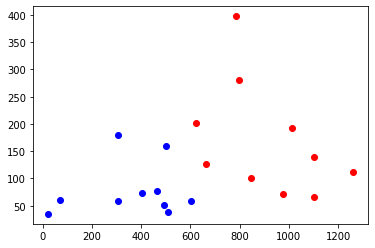

In [275]:
X = [ Zs_AC_01[i][1] for i in np.arange(len(Zs_AC_01)) ]  
Y = [ Zs_AC_01[i][2] for i in np.arange(len(Zs_AC_01)) ]

#plt.scatter(np.absolute(X), np.absolute(X))
x = np.absolute(X)
y = np.absolute(Y)
plt.scatter(x[0:10], y[0:10], color='blue') #the zeros
plt.scatter(x[10:] , y[10:],  color='red')  #the ones
#plt.scatter(x[12],y[12], color='green') # an outlier but why ?
plt.show()


### 1.3 Additional method(s)
Using FindContour function from OpenCV, which is more performant than active contour...

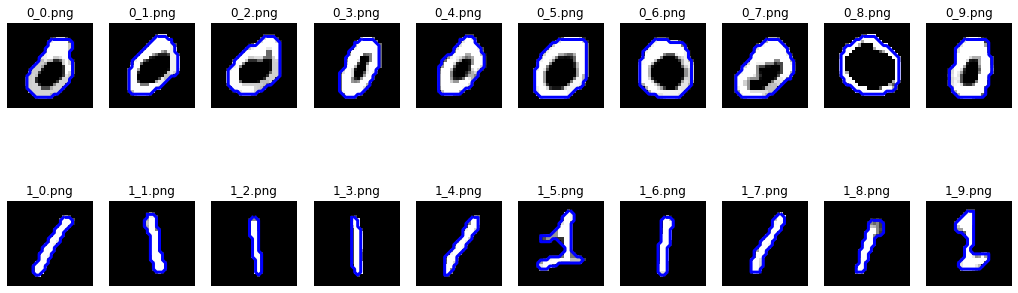

In [276]:
Zs_CV2_01 = [ [] for i in np.arange( len(zeros_im) + len(ones_im) ) ]
snakes = list(im) #copy only the content, not the reference
im_prepro = list(im) #copy only the content, not the reference
for idx in np.arange(len(zeros_im)):
    Zs_CV2_01[idx], snakes[idx], im_prepro[idx] = extract_fourier_descriptor(zeros_im[idx], "CV2")
    Zs_CV2_01[idx + len(zeros_im)], snakes[idx+ len(zeros_im)], im_prepro[idx+ len(zeros_im)] = extract_fourier_descriptor(ones_im[idx], "CV2")
    

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(18, 6))
for idx, ax, im, nm in zip(np.arange(len(zeros_im)), axes[0], zeros_im, zeros_names):
    #ax.plot(init[:, 1], init[:, 0], '--r', lw=3)  #initial snake, not needed
    ax.plot(snakes[idx][:, 1], snakes[idx][:, 0], '-b', lw=3)
    ax.imshow(im_prepro[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for idx, ax, im, nm in zip(np.arange(len(ones_im)), axes[1], ones_im, ones_names):
    ax.plot(snakes[idx+ len(zeros_im)][:, 1], snakes[idx+ len(zeros_im)][:, 0], '-b', lw=3)
    ax.imshow(im_prepro[idx+ len(zeros_im)], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

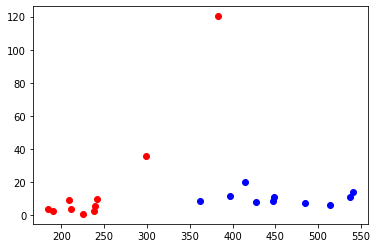

In [277]:
X = [ Zs_CV2_01[i][1] for i in np.arange(len(Zs_CV2_01)) ]  
Y = [ Zs_CV2_01[i][2] for i in np.arange(len(Zs_CV2_01)) ]

#plt.scatter(np.absolute(X), np.absolute(X))
x = np.absolute(X)
y = np.absolute(Y)
plt.scatter(x[0:10], y[0:10], color='blue') #the zeros
plt.scatter(x[10:] , y[10:],  color='red')  #the ones
#plt.scatter(x[12],y[12], color='green') # an outlier but why ?
plt.show()


## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

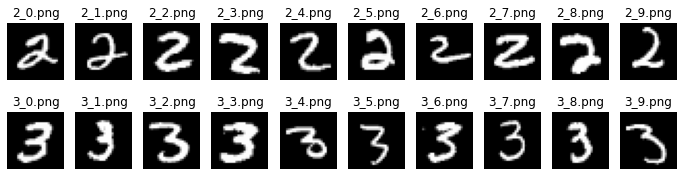

In [278]:
#  Load twos
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load threes
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

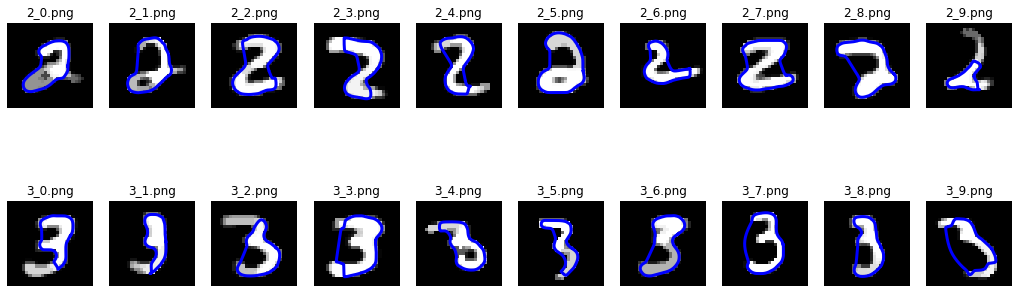

In [279]:
Zs_AC_23 = [ [] for i in np.arange( len(zeros_im) + len(ones_im) ) ]
snakes = list(im) #copy only the content, not the reference
im_prepro = list(im) #copy only the content, not the reference
for idx in np.arange(len(twos_im)):
    Zs_AC_23[idx], snakes[idx], im_prepro[idx] = extract_fourier_descriptor(twos_im[idx], "AC")
    Zs_AC_23[idx + len(zeros_im)], snakes[idx+ len(twos_im)], im_prepro[idx+ len(twos_im)] = extract_fourier_descriptor(threes_im[idx], "AC")
    

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(18, 6))
for idx, ax, im, nm in zip(np.arange(len(twos_im)), axes[0], twos_im, twos_names):
    #ax.plot(init[:, 1], init[:, 0], '--r', lw=3)  #initial snake, not needed
    ax.plot(snakes[idx][:, 1], snakes[idx][:, 0], '-b', lw=3)
    ax.imshow(im_prepro[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for idx, ax, im, nm in zip(np.arange(len(threes_im)), axes[1], threes_im, threes_names):
    ax.plot(snakes[idx+ len(threes_im)][:, 1], snakes[idx+ len(threes_im)][:, 0], '-b', lw=3)
    ax.imshow(im_prepro[idx+ len(threes_im)], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

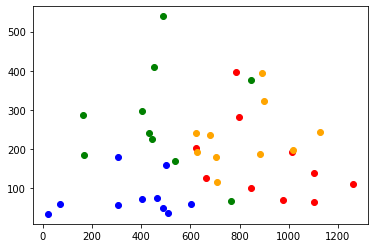

In [285]:
X = np.concatenate(([ Zs_AC_01[i][1] for i in np.arange(len(Zs_AC_01))], [ Zs_AC_23[i][1] for i in np.arange(len(Zs_AC_23))]))
Y = np.concatenate(([ Zs_AC_01[i][2] for i in np.arange(len(Zs_AC_01))], [ Zs_AC_23[i][2] for i in np.arange(len(Zs_AC_23))]))

#plt.scatter(np.absolute(X), np.absolute(X))
x = np.absolute(X)
y = np.absolute(Y)

plt.scatter(x[0:10], y[0:10], color='blue') #the zeros
plt.scatter(x[10:20] , y[10:20],  color='red')  #the ones
plt.scatter(x[20:30] , y[20:30],  color='green')  #the twos
plt.scatter(x[30:40] , y[30:40],  color='orange')  #the threes
#plt.scatter(x[12],y[12], color='green') # an outlier but why ?
plt.show()

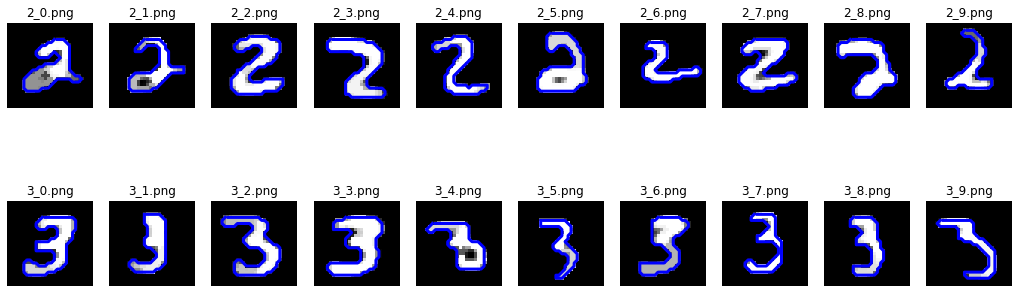

In [286]:
Zs_CV2_23 = [ [] for i in np.arange( len(zeros_im) + len(ones_im) ) ]
snakes = list(im) #copy only the content, not the reference
im_prepro = list(im) #copy only the content, not the reference
for idx in np.arange(len(twos_im)):
    Zs_CV2_23[idx], snakes[idx], im_prepro[idx] = extract_fourier_descriptor(twos_im[idx], "CV2")
    Zs_CV2_23[idx + len(zeros_im)], snakes[idx+ len(twos_im)], im_prepro[idx+ len(twos_im)] = extract_fourier_descriptor(threes_im[idx], "CV2")
    

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(18, 6))
for idx, ax, im, nm in zip(np.arange(len(twos_im)), axes[0], twos_im, twos_names):
    #ax.plot(init[:, 1], init[:, 0], '--r', lw=3)  #initial snake, not needed
    ax.plot(snakes[idx][:, 1], snakes[idx][:, 0], '-b', lw=3)
    ax.imshow(im_prepro[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for idx, ax, im, nm in zip(np.arange(len(threes_im)), axes[1], threes_im, threes_names):
    ax.plot(snakes[idx+ len(threes_im)][:, 1], snakes[idx+ len(threes_im)][:, 0], '-b', lw=3)
    ax.imshow(im_prepro[idx+ len(threes_im)], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

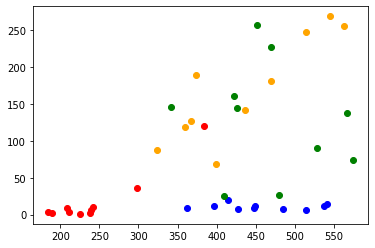

In [287]:
X = np.concatenate(([ Zs_CV2_01[i][1] for i in np.arange(len(Zs_CV2_01))], [ Zs_CV2_23[i][1] for i in np.arange(len(Zs_CV2_23))]))
Y = np.concatenate(([ Zs_CV2_01[i][2] for i in np.arange(len(Zs_CV2_01))], [ Zs_CV2_23[i][2] for i in np.arange(len(Zs_CV2_23))]))

#plt.scatter(np.absolute(X), np.absolute(X))
x = np.absolute(X)
y = np.absolute(Y)

plt.scatter(x[0:10], y[0:10], color='blue') #the zeros
plt.scatter(x[10:20] , y[10:20],  color='red')  #the ones
plt.scatter(x[20:30] , y[20:30],  color='green')  #the twos
plt.scatter(x[30:40] , y[30:40],  color='orange')  #the threes
#plt.scatter(x[12],y[12], color='green') # an outlier but why ?
plt.show()